# Multiclass Support Vector Machine exercise


- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

In [2]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0) # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = "cs231n/datasets/cifar-10-batches-py"
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, print out the size of the training and test data.
print("Training data shape: ", X_train.shape)
print("Training labels shape: ", y_train.shape)
print("Test data shape: ", X_test.shape)
print("Test labels shape: ", y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


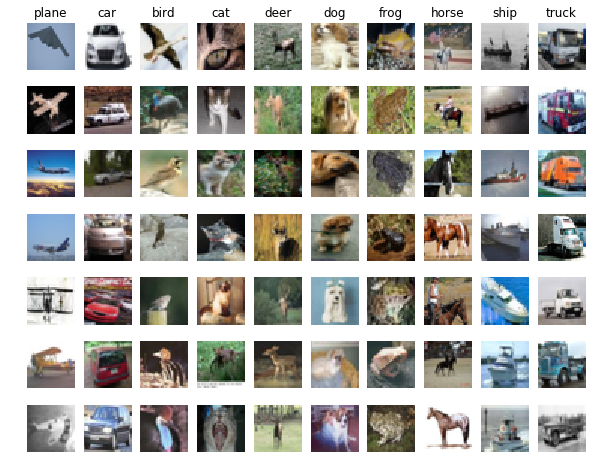

In [4]:
# Visualize some examples from the dataset.
classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype("uint8"))
        plt.axis("off")
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print("Train data shape: ", X_train.shape)
print("Train labels shape: ", y_train.shape)
print("Validation data shape: ", X_val.shape)
print("Validation labels shape: ", y_val.shape)
print("Test data shape: ", X_test.shape)
print("Test labels shape: ", y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [6]:
# Preprocessing: reshape the image data into rows.
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data.
print("Training data shape: ", X_train.shape)
print("Validation data shape: ", X_val.shape)
print("Test data shape: ", X_test.shape)
print("dev data shape: ", X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


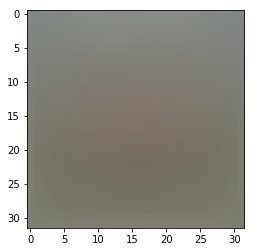

In [7]:
# Preprocessing: subtract the mean image
# First: compute the image mean based on the training data.
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype("uint8")) # visualize the mean image
plt.show()

In [8]:
# Second: subtract the mean image from train and test data.
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [9]:
# Third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Relevant code is in **cs231n/classifiers/linear_svm.py**. 

In [10]:
# Evaluate the naive implementation of the loss.
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# Generate a random SVM weight matrix of small numbers.
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print("loss: %f" % (loss, ))

loss: 8.938019


In [11]:
# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# Repeat the check with regularisation enabled.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -6.159294 analytic: -6.159294, relative error: 2.972119e-11
numerical: 14.003386 analytic: 14.003386, relative error: 1.539437e-11
numerical: 2.878526 analytic: 2.878526, relative error: 1.166210e-10
numerical: 10.085404 analytic: 10.085404, relative error: 2.555799e-11
numerical: 15.747077 analytic: 15.747077, relative error: 3.892918e-12
numerical: -10.215528 analytic: -10.215528, relative error: 1.964081e-11
numerical: 5.447876 analytic: 5.447876, relative error: 6.757296e-11
numerical: 27.747460 analytic: 27.747460, relative error: 4.489825e-12
numerical: -18.795521 analytic: -18.795521, relative error: 2.390308e-11
numerical: 2.705022 analytic: 2.705022, relative error: 1.857526e-11
numerical: -49.427951 analytic: -49.433971, relative error: 6.089015e-05
numerical: 5.173222 analytic: 5.176262, relative error: 2.937269e-04
numerical: 21.607137 analytic: 21.597343, relative error: 2.266844e-04
numerical: 1.644028 analytic: 1.650735, relative error: 2.035472e-03
numerical:

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** 
This is because of the max function, which is not strictly speaking differentiable; at the "hinge" point where we switch between functions (SVM loss and 0), the slopes are not equal and there is no real gradient. In one dimension, this would be where x = 0.

In [70]:
# Calculate the loss with the vectorised implementation.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print("Naive loss: %e computed in %fs" % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print("Vectorized loss: %e computed in %fs" % (loss_vectorized, toc - tic))

# The losses should match but your vectorised implementation should be much faster.
print("difference: %f" % (loss_naive - loss_vectorized))

Naive loss: 8.938019e+00 computed in 0.070413s
Vectorized loss: 8.938019e+00 computed in 0.011289s
difference: 0.000000


In [71]:
# Calculate the gradient with the vectorised implementation.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print("Naive loss and gradient: computed in %fs" % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print("Vectorized loss and gradient: computed in %fs" % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord="fro")
print("difference: %f" % difference)

Naive loss and gradient: computed in 0.070577s
Vectorized loss and gradient: computed in 0.002013s
difference: 0.000000


### Stochastic Gradient Descent
Relevant code is in **cs231n/classifiers/linear_classifier.py**. 


In [72]:
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,num_iters=1500, verbose=True)
toc = time.time()
print("That took %fs" % (toc - tic))

iteration 0 / 1500: loss 785.308007
iteration 100 / 1500: loss 470.222572
iteration 200 / 1500: loss 284.931207
iteration 300 / 1500: loss 173.568024
iteration 400 / 1500: loss 105.865973
iteration 500 / 1500: loss 65.815656
iteration 600 / 1500: loss 42.070315
iteration 700 / 1500: loss 27.545579
iteration 800 / 1500: loss 19.049182
iteration 900 / 1500: loss 13.912903
iteration 1000 / 1500: loss 10.452370
iteration 1100 / 1500: loss 7.993394
iteration 1200 / 1500: loss 7.198483
iteration 1300 / 1500: loss 6.772481
iteration 1400 / 1500: loss 6.268581
That took 3.787642s


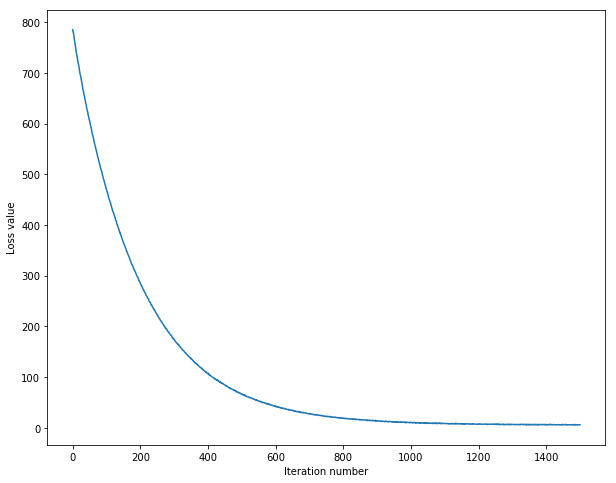

In [73]:
# Plot the loss as function of iteration number. 
plt.plot(loss_hist)
plt.xlabel("Iteration number")
plt.ylabel("Loss value")
plt.show()

In [64]:
# Evaluate predictive performance on the training and validation set. 
y_train_pred = svm.predict(X_train)
print("training accuracy: %f" % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print("validation accuracy: %f" % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.377102
validation accuracy: 0.397000


In [66]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). 
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

for reg in regularization_strengths:
    for rate in learning_rates:
        svm = LinearSVM()
        loss_hist = svm.train(X_train, y_train, rate, reg, num_iters=1500)
        y_train_pred = svm.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm           
        results[(rate,reg)] = train_accuracy,val_accuracy
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print("lr %e reg %e train accuracy: %f val accuracy: %f" % (
                lr, reg, train_accuracy, val_accuracy))
    
print("Best validation accuracy achieved during cross-validation: %f" % best_val)

/home/mark/Dropbox/Side Projects/cs231n/assignment 1/assignment1/cs231n/classifiers/linear_svm.py:85: RuntimeWarning: overflow encountered in double_scalars
  # Calculate average loss across margins.
/home/mark/Dropbox/Side Projects/cs231n/assignment 1/assignment1/cs231n/classifiers/linear_svm.py:85: RuntimeWarning: overflow encountered in multiply
  # Calculate average loss across margins.


lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.377531 val accuracy: 0.397000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.367449 val accuracy: 0.369000
lr 5.000000e-05 reg 2.500000e+04 train accuracy: 0.135082 val accuracy: 0.135000
lr 5.000000e-05 reg 5.000000e+04 train accuracy: 0.053388 val accuracy: 0.046000
best validation accuracy achieved during cross-validation: 0.397000


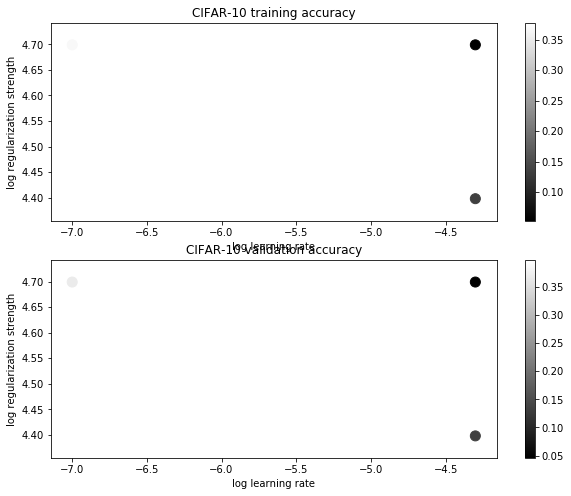

In [74]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel("log learning rate")
plt.ylabel("log regularization strength")
plt.title("CIFAR-10 training accuracy")

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel("log learning rate")
plt.ylabel("log regularization strength")
plt.title("CIFAR-10 validation accuracy")
plt.show()

In [68]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print("Linear SVM on raw pixels final test set accuracy: %f" % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.380000


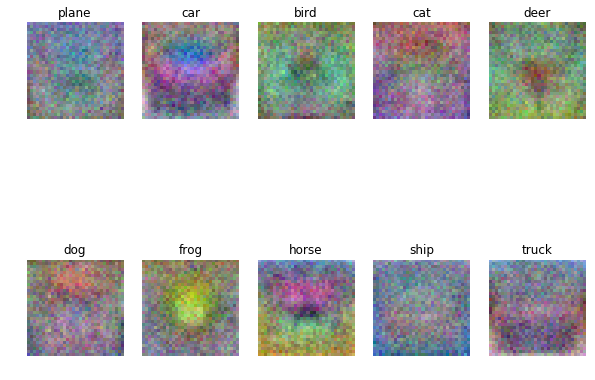

In [69]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype("uint8"))
    plt.axis("off")
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** The visualised SVM weights are rough templates for their corresponding objects. Essentially, the SVM compares the similarity of images to these templates.